In [1]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs
# basemap toolkit to plot maps
from mpl_toolkits.basemap import Basemap

%pylab inline

import cosima_cookbook as cc
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
from glob import glob as gb
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

session = cc.database.create_session()

Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
!pwd

/home/561/erd561/wombat_jra-iaf_mom025


In [4]:
figures_path = '/home/561/erd561/figures/JRA_IAF_v13/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

jra55_path = '/g/data/ua8/JRA55-do/v1-3/'

# accessom2_path = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf/'
accessom2_path = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/'

Figures will be saved in: /home/561/erd561/figures/JRA_IAF_v13/c08_temp_tau_x_eta_t



In [5]:
%%time

c = Client()
print(c)

<Client: 'tcp://127.0.0.1:35754' processes=4 threads=8, memory=33.67 GB>
CPU times: user 530 ms, sys: 128 ms, total: 658 ms
Wall time: 2.99 s


In [6]:
years = np.arange(2218, 2258)
years_id = np.arange(2218, 2258, 2)
n_years = np.arange(1978, 2018)

print(years)
print(len(years))

output_n = ["%03d" % i for i in range(130,150)]
print(output_n)
print(len(output_n))

[2218 2219 2220 2221 2222 2223 2224 2225 2226 2227 2228 2229 2230 2231
 2232 2233 2234 2235 2236 2237 2238 2239 2240 2241 2242 2243 2244 2245
 2246 2247 2248 2249 2250 2251 2252 2253 2254 2255 2256 2257]
40
['130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149']
20


In [7]:
# use common start and end dates for all runs
# tstart = exptdata.clim_tstart
tstart = '1978-01-01 00:00:00'
tend = exptdata.clim_tend

firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

output_dir = '/home/561/erd561/figures/Australia/'
fig_name = nb_name[:-6]
fig_dir = output_dir + fig_name

output_ls = os.listdir(output_dir)
if fig_name not in output_ls:
    os.mkdir(fig_dir) 

1978-2017
tstart =  1978-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [8]:
latS = -60
latN = -20
lonW = -260
lonE = -190
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
time_units = exptdata.exptdict[ekey]['time_units']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
print(expt)
print(time_units)
print(n_files)
print(offset)
# temp_month = cc.querying.getvar(expt=expt,
#                                 variable='temp',
#                                 session=session,
#                                 ncfile='ocean.nc',
#                                 n=n_files,
#                                 offset=offset).\
#                             sel(time=slice(tstart,tend)).\
#                             sel(yt_ocean=slice(latS,latN)).\
#                             sel(xt_ocean=slice(lonW,lonE)).\
#                             sel(st_ocean=0,method='nearest')
temp_month = cc.querying.getvar(expt=expt,
                                variable='temp',
                                session=session,
                                ncfile='ocean.nc',
                                n=n_files,
                                offset=offset).\
                            sel(yt_ocean=slice(latS,latN)).\
                            sel(xt_ocean=slice(lonW,lonE)).\
                            sel(st_ocean=0,method='nearest')

temp_month.load()

temp = temp_month.groupby('time.year').mean('time')
temp = temp.sel(year=slice(1978,2017))

xt_ocean = temp.xt_ocean
xt_ocean_corrected = xt_ocean + 360
temp = temp.assign_coords(xt_ocean=xt_ocean_corrected)
print(temp)

025deg_jra55v13_iaf_gmredi6
days since 1718-01-01
-34
-87658


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/cosima_cookbook/querying.py:96: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  preprocess=lambda d: d[variable].to_dataset() if variable not in d.coords else d)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option t

<xarray.DataArray 'temp' (year: 40, yt_ocean: 220, xt_ocean: 280)>
array([[[272.5063 , 272.5297 , 272.5534 , ..., 276.11627, 276.16214,
         276.22318],
        [272.5527 , 272.57562, 272.59445, ..., 276.19135, 276.24188,
         276.30597],
        [272.59995, 272.6216 , 272.63828, ..., 276.27237, 276.32352,
         276.38934],
        ...,
        [296.34662, 296.3134 , 296.29318, ..., 297.9321 , 297.93143,
         297.9177 ],
        [296.4749 , 296.45575, 296.4578 , ..., 298.0363 , 298.02942,
         298.02402],
        [296.646  , 296.62845, 296.5906 , ..., 298.1591 , 298.15842,
         298.14905]],

       [[272.9055 , 272.922  , 272.93787, ..., 275.9116 , 275.9297 ,
         275.98596],
        [272.93976, 272.95718, 272.96857, ..., 276.00165, 276.0128 ,
         276.0658 ],
        [272.9709 , 272.98734, 272.9991 , ..., 276.09915, 276.1147 ,
         276.15906],
        ...,
        [296.21423, 296.20197, 296.1811 , ..., 298.13962, 298.15198,
         298.14557],
     

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
tau_x_month = cc.querying.getvar(expt=expt,
                                variable='tau_x',
                                session=session,
                                ncfile='ocean_month.nc',
                                n=n_files,
                                offset=offset).\
                            sel(yu_ocean=slice(latS,latN)).\
                            sel(xu_ocean=slice(lonW,lonE))

tau_x_month.load()

tau_x = tau_x_month.groupby('time.year').mean('time')
tau_x = tau_x.sel(year=slice(1978,2017))

xu_ocean = tau_x.xu_ocean
xu_ocean_corrected = xu_ocean + 360
tau_x = tau_x.assign_coords(xu_ocean=xu_ocean_corrected)
print(tau_x)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/cosima_cookbook/querying.py:96: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  preprocess=lambda d: d[variable].to_dataset() if variable not in d.coords else d)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option t

<xarray.DataArray 'tau_x' (year: 40, yu_ocean: 220, xu_ocean: 281)>
array([[[ 0.05998706,  0.05998732,  0.06011894, ...,  0.15865918,
          0.15879817,  0.15885141],
        [ 0.0635025 ,  0.06350302,  0.06352918, ...,  0.1602141 ,
          0.1604364 ,  0.16063628],
        [ 0.06690311,  0.06685285,  0.06695293, ...,  0.16141018,
          0.16192631,  0.16244417],
        ...,
        [-0.06575809, -0.06478459, -0.06356924, ..., -0.04937483,
         -0.05006254, -0.05068464],
        [-0.06627791, -0.06536387, -0.06412879, ..., -0.05007763,
         -0.050768  , -0.05138131],
        [-0.06644477, -0.06537809, -0.06407737, ..., -0.05029038,
         -0.05095332, -0.05122823]],

       [[ 0.09659341,  0.09584936,  0.0952599 , ...,  0.17508036,
          0.17536134,  0.17562181],
        [ 0.10128426,  0.10053226,  0.09983277, ...,  0.17646454,
          0.17670976,  0.17719932],
        [ 0.10576203,  0.1049682 ,  0.10433695, ...,  0.17806135,
          0.17845954,  0.17919664],

In [10]:
eta_t_month = cc.querying.getvar(expt=expt,
                                variable='eta_t',
                                session=session,
                                ncfile='ocean_month.nc',
                                n=n_files,
                                offset=offset).\
                            sel(yt_ocean=slice(latS,latN)).\
                            sel(xt_ocean=slice(lonW,lonE))

eta_t_month.load()

eta_t = eta_t_month.groupby('time.year').mean('time')*100
eta_t = eta_t.sel(year=slice(1978,2017))

xt_ocean = eta_t.xt_ocean
xt_ocean_corrected = xt_ocean + 360
eta_t = eta_t.assign_coords(xt_ocean=xt_ocean_corrected)
print(eta_t)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/cosima_cookbook/querying.py:96: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  preprocess=lambda d: d[variable].to_dataset() if variable not in d.coords else d)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option t

<xarray.DataArray 'eta_t' (year: 40, yt_ocean: 220, xt_ocean: 280)>
array([[[-181.71002 , -181.51251 , -181.2364  , ..., -126.04009 ,
         -125.4059  , -124.51856 ],
        [-180.96219 , -180.72826 , -180.43765 , ..., -124.47202 ,
         -123.763885, -122.86788 ],
        [-180.12553 , -179.84508 , -179.58464 , ..., -122.73176 ,
         -122.042534, -121.14519 ],
        ...,
        [  39.09323 ,   38.785072,   38.66992 , ...,   61.674988,
           61.77823 ,   61.662273],
        [  40.20345 ,   40.005352,   39.85035 , ...,   61.901146,
           62.018276,   62.04215 ],
        [  41.321228,   41.197594,   41.071365, ...,   62.122047,
           62.269264,   62.23868 ]],

       [[-183.39749 , -183.18996 , -182.90442 , ..., -126.25247 ,
         -125.99042 , -125.184906],
        [-182.70668 , -182.46194 , -182.15182 , ..., -124.65397 ,
         -124.35886 , -123.58893 ],
        [-181.93507 , -181.64488 , -181.35046 , ..., -122.897316,
         -122.60698 , -121.853386],

In [11]:
temp_anom = temp - temp.mean(dim='year')
tau_x_anom = tau_x - tau_x.mean(dim='year')
eta_t_anom = eta_t - eta_t.mean(dim='year')

yt_ocean = temp.yt_ocean
xt_ocean = temp.xt_ocean
temp_slopes = xr.DataArray(np.zeros([yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[yt_ocean, xt_ocean], name='temp')
for iid, i in enumerate(yt_ocean):
    for jid, j in enumerate(xt_ocean):
        temp_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(n_years, temp.sel(xt_ocean=j, yt_ocean=i))
    print('lat ' + str(np.array(i)))
print(temp_slopes)    

yu_ocean = tau_x.yu_ocean
xu_ocean = tau_x.xu_ocean
tau_x_slopes = xr.DataArray(np.zeros([yu_ocean.shape[0], xu_ocean.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[yu_ocean, xu_ocean], name='tau_x')
for iid, i in enumerate(yu_ocean):
    for jid, j in enumerate(xu_ocean):        
        tau_x_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(n_years, tau_x.sel(xu_ocean=j, yu_ocean=i))
    print('lat ' + str(np.array(i)))
print(tau_x_slopes)

eta_t_slopes = xr.DataArray(np.zeros([yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[yt_ocean, xt_ocean], name='eta_t')
for iid, i in enumerate(yt_ocean):
    for jid, j in enumerate(xt_ocean):        
        eta_t_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(n_years, eta_t.sel(xt_ocean=j, yt_ocean=i))
    print('lat ' + str(np.array(i)))
print(eta_t_slopes)

lat -59.95944891414468
lat -59.83405816024584
lat -59.70819585940245
lat -59.581856103011404
lat -59.45504242360883
lat -59.32774895769571
lat -59.19997921240009
lat -59.071727369439934
lat -58.942996911365846
lat -58.81378206523734
lat -58.68408628986453
lat -58.55390385778473
lat -58.42323820491095
lat -58.29208364940619
lat -58.16044360513618
lat -58.02831243604918
lat -57.89569353481996
lat -57.76258131135323
lat -57.62897913799566
lat -57.4948814707912
lat -57.360291662627816
lat -57.22520421588314
lat -57.08962246486236
lat -56.95354095848275
lat -56.816963013349266
lat -56.67988322513629
lat -56.542304893637656
lat -56.40422266151375
lat -56.26563981264301
lat -56.12655103691214
lat -55.98695960318641
lat -55.84686024883049
lat -55.706256228605255
lat -55.56514232761621
lat -55.423521787435156
lat -55.281389441182455
lat -55.13874851816258
lat -54.99559389979584
lat -54.85192880404753
lat -54.70774816093398
lat -54.56305517801577
lat -54.417844834212126
lat -54.2721203276197
lat

lat -46.56960151887808
lat -46.3974611875969
lat -46.22477609339097
lat -46.05154608040137
lat -45.877771023025645
lat -45.70345080450018
lat -45.528585338572775
lat -45.353174548345784
lat -45.17721838768866
lat -45.000716820340045
lat -44.823669841061836
lat -44.64607745499846
lat -44.467939698573915
lat -44.28925661910647
lat -44.11002829545008
lat -43.93025481786292
lat -43.74993630839449
lat -43.56907290100625
lat -43.38766476170589
lat -43.20571206891831
lat -43.02321503336839
lat -42.840173878700725
lat -42.65658886111221
lat -42.472460250218845
lat -42.28778834843945
lat -42.102573472107835
lat -41.91681597060906
lat -41.730516207735334
lat -41.54367458057595
lat -41.35629150111541
lat -41.168367414878254
lat -40.97990278276779
lat -40.79089809946711
lat -40.60135387551674
lat -40.41127065547309
lat -40.22064900022349
lat -40.02948950490317
lat -39.83779278144622
lat -39.6455594762622
lat -39.452790253021426
lat -39.25948581009248
lat -39.06564686356021
lat -38.87127416442522
l

lat -29.2630432019257
lat -29.044715107989248
lat -28.82592266049411
lat -28.606670794106993
lat -28.38695904216067
lat -28.166792391212045
lat -27.946170449161986
lat -27.72509825470525
lat -27.50357549012893
lat -27.28160724647727
lat -27.059193280207044
lat -26.83633873488693
lat -26.61304344089147
lat -26.389312594451354
lat -26.165146099570944
lat -25.940549205242547
lat -25.715521888775697
lat -25.490069451985352
lat -25.264191945124278
lat -25.037894722851966
lat -24.811177907964588
lat -24.58404690794839
lat -24.356501917704698
lat -24.12854839748857
lat -23.90018661382929
lat -23.671422079652153
lat -23.442255132597825
lat -23.212691338122195
lat -22.982731104420896
lat -22.75238004929935
lat -22.52163865091151
lat -22.290512579189507
lat -22.05900238160839
lat -21.827113779962115
lat -21.594847390368724
lat -21.362208986176793
lat -21.129199251428126
lat -20.89582401067619
lat -20.66208401512598
lat -20.427985140143456
lat -20.193528203294715
<xarray.DataArray 'eta_t' (latitu

In [12]:
years = np.arange(2198, 2218)
years_id = np.arange(2198, 2218, 2)
n_years = np.arange(1958, 1978)

print(years)
print(len(years))

output_n = ["%03d" % i for i in range(120,130)]
print(output_n)
print(len(output_n))

tau_x_dir = 'ocean/ocean_month.nc'
tau_x_path = []
for oid, o in enumerate(output_n):
    for t in np.arange(2):
        print(str(years_id[oid]+t) + ' OK')
        path_now = accessom2_path + 'output' + o + '/' + tau_x_dir

        if o == output_n[0] and t == 0:
            tau_x_bl = xr.open_dataset(path_now).\
            tau_x.\
            sel(xu_ocean=slice(-260,-190)).\
            sel(yu_ocean=slice(-60,-20)).\
            sel(time= slice(str(years_id[oid]+t) + '-01-14', str(years_id[oid]+t) + '-12-14')).\
            mean(dim='time')
            
        else:
            tau_x_bl = xr.concat([
                tau_x_bl,
                xr.open_dataset(path_now).\
                tau_x.\
                sel(xu_ocean=slice(-260,-190)).\
                sel(yu_ocean=slice(-60,-20)).\
                sel(time= slice(str(years_id[oid]+t) + '-01-14', str(years_id[oid]+t) + '-12-14')).\
                mean(dim='time')
                ], 'time'
                )
tau_x_bl = tau_x_bl.assign_coords(xu_ocean=xu_ocean_corrected)
tau_x_bl = tau_x_bl.assign_coords(time=n_years)
print(tau_x_bl)

tau_x_bl_mean = tau_x_bl.mean(dim='time')
print(tau_x_bl_mean)


years = np.arange(2218, 2258)
years_id = np.arange(2218, 2258, 2)
n_years = np.arange(1978, 2018)
output_n = ["%03d" % i for i in range(130,150)]

[2198 2199 2200 2201 2202 2203 2204 2205 2206 2207 2208 2209 2210 2211
 2212 2213 2214 2215 2216 2217]
20
['120', '121', '122', '123', '124', '125', '126', '127', '128', '129']
10
2198 OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2199 OK
2200 OK


ValueError: 'time' is not present in all datasets

In [13]:
n_years

array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977])

In [25]:
years_comp = 8
temp_slopes_40 = temp_slopes * 10
tau_x_slopes_40 = tau_x_slopes * 10
eta_t_slopes_40 = eta_t_slopes * 10

n_years = np.arange(1978, 2018)

lon_SA = [112, 145]
lat_SA = [-41, -31]
temp_anom_SA = temp_anom.\
sel(xt_ocean=slice(lon_SA[0],lon_SA[1])).\
sel(yt_ocean=slice(lat_SA[0],lat_SA[1])).\
mean(dim='xt_ocean').\
mean(dim='yt_ocean')
temp_anom_SA_slope, temp_anom_SA_intrsct, temp_anom_SA_r_value, temp_anom_SA_p_value, temp_anom_SA_std_err = \
        stats.linregress(n_years, temp_anom_SA)
tau_x_anom_SA = tau_x_anom.\
sel(xu_ocean=slice(lon_SA[0],lon_SA[1])).\
sel(yu_ocean=slice(lat_SA[0],lat_SA[1])).\
mean(dim='xu_ocean').\
mean(dim='yu_ocean')
tau_x_anom_SA_slope, tau_x_anom_SA_intrsct, tau_x_anom_SA_r_value, tau_x_anom_SA_p_value, tau_x_anom_SA_std_err = \
        stats.linregress(n_years, tau_x_anom_SA)
temp_anom_SA_sort = np.sort(temp_anom_SA)
temp_warm_SA = xr.DataArray(np.zeros([years_comp, yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'year', 'latitude', 'longitude'), coords=[np.arange(years_comp), yt_ocean, xt_ocean], name='temp')
tau_x_warm_SA = xr.DataArray(np.zeros([years_comp, yu_ocean.shape[0], xu_ocean.shape[0]]), dims=(
    'year', 'latitude', 'longitude'), coords=[np.arange(years_comp), yu_ocean, xu_ocean], name='tau_x')
temp_cold_SA = xr.DataArray(np.zeros([years_comp, yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'year', 'latitude', 'longitude'), coords=[np.arange(years_comp), yt_ocean, xt_ocean], name='temp')
tau_x_cold_SA = xr.DataArray(np.zeros([years_comp, yu_ocean.shape[0], xu_ocean.shape[0]]), dims=(
    'year', 'latitude', 'longitude'), coords=[np.arange(years_comp), yu_ocean, xu_ocean], name='tau_x')
years_warm_SA = []
years_cold_SA = []
temp_anom_SA_warm_unsort = []
tau_x_anom_SA_warm_unsort = []
temp_anom_SA_cold_unsort = []
tau_x_anom_SA_cold_unsort = []
tw=-1
tc=-1
for y in n_years:
    if np.array(temp_anom_SA.sel(year=y)) in temp_anom_SA_sort[-years_comp:]:
        tw+=1
        years_warm_SA.append(y)
        temp_anom_SA_warm_unsort.append(np.array(temp_anom_SA.sel(year=y)))
        tau_x_anom_SA_warm_unsort.append(np.array(tau_x_anom_SA.sel(year=y)))
        temp_warm_SA[tw,:,:] = temp_anom.sel(year=y)
        tau_x_warm_SA[tw,:,:] = tau_x_anom.sel(year=y)
    if np.array(temp_anom_SA.sel(year=y)) in temp_anom_SA_sort[:years_comp]:
        tc+=1
        years_cold_SA.append(y)
        temp_anom_SA_cold_unsort.append(np.array(temp_anom_SA.sel(year=y)))
        tau_x_anom_SA_cold_unsort.append(np.array(tau_x_anom_SA.sel(year=y)))
        temp_cold_SA[tc,:,:] = temp_anom.sel(year=y)
        tau_x_cold_SA[tc,:,:] = tau_x_anom.sel(year=y)
temp_warm_composite_SA = temp_warm_SA.mean(dim='year')
tau_x_warm_composite_SA = tau_x_warm_SA.mean(dim='year')
temp_cold_composite_SA = temp_cold_SA.mean(dim='year')
tau_x_cold_composite_SA = tau_x_cold_SA.mean(dim='year')
years_extremes_SA = np.concatenate([years_cold_SA, years_warm_SA])
temp_extremes_SA = np.concatenate([temp_anom_SA_cold_unsort, temp_anom_SA_warm_unsort])
tau_x_extremes_SA = np.concatenate([tau_x_anom_SA_cold_unsort, tau_x_anom_SA_warm_unsort])



lon_TS = [148, 157]
lat_TS = [-45, -32]
temp_anom_TS = temp_anom.\
sel(xt_ocean=slice(lon_TS[0],lon_TS[1])).\
sel(yt_ocean=slice(lat_TS[0],lat_TS[1])).\
mean(dim='xt_ocean').\
mean(dim='yt_ocean')
temp_anom_TS_slope, temp_anom_TS_intrsct, temp_anom_TS_r_value, temp_anom_TS_p_value, temp_anom_TS_std_err = \
        stats.linregress(n_years, temp_anom_TS)
eta_t_anom_TS = eta_t_anom.\
sel(xt_ocean=slice(lon_TS[0],lon_TS[1])).\
sel(yt_ocean=slice(lat_TS[0],lat_TS[1])).\
mean(dim='xt_ocean').\
mean(dim='yt_ocean')
eta_t_anom_TS_slope, eta_t_anom_TS_intrsct, eta_t_anom_TS_r_value, eta_t_anom_TS_p_value, eta_t_anom_TS_std_err = \
        stats.linregress(n_years, eta_t_anom_TS)
temp_anom_TS_sort = np.sort(temp_anom_TS)
temp_warm_TS = xr.DataArray(np.zeros([years_comp, yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'year', 'latitude', 'longitude'), coords=[np.arange(years_comp), yt_ocean, xt_ocean], name='temp')
eta_t_warm_TS = xr.DataArray(np.zeros([years_comp, yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'year', 'latitude', 'longitude'), coords=[np.arange(years_comp), yt_ocean, xt_ocean], name='eta_t')
temp_cold_TS = xr.DataArray(np.zeros([years_comp, yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'year', 'latitude', 'longitude'), coords=[np.arange(years_comp), yt_ocean, xt_ocean], name='temp')
eta_t_cold_TS = xr.DataArray(np.zeros([years_comp, yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'year', 'latitude', 'longitude'), coords=[np.arange(years_comp), yt_ocean, xt_ocean], name='eta_t')
years_warm_TS = []
years_cold_TS = []
temp_anom_TS_warm_unsort = []
eta_t_anom_TS_warm_unsort = []
temp_anom_TS_cold_unsort = []
eta_t_anom_TS_cold_unsort = []
tw=-1
tc=-1
for y in n_years:
    if np.array(temp_anom_TS.sel(year=y)) in temp_anom_TS_sort[-years_comp:]:
        tw+=1
        years_warm_TS.append(y)
        temp_anom_TS_warm_unsort.append(np.array(temp_anom_TS.sel(year=y)))
        eta_t_anom_TS_warm_unsort.append(np.array(eta_t_anom_TS.sel(year=y)))
        temp_warm_TS[tw,:,:] = temp_anom.sel(year=y)
        eta_t_warm_TS[tw,:,:] = eta_t_anom.sel(year=y)
    if np.array(temp_anom_TS.sel(year=y)) in temp_anom_TS_sort[:years_comp]:
        tc+=1
        years_cold_TS.append(y)
        temp_anom_TS_cold_unsort.append(np.array(temp_anom_TS.sel(year=y)))
        eta_t_anom_TS_cold_unsort.append(np.array(eta_t_anom_TS.sel(year=y)))
        temp_cold_TS[tc,:,:] = temp_anom.sel(year=y)
        eta_t_cold_TS[tc,:,:] = eta_t_anom.sel(year=y)
temp_warm_composite_TS = temp_warm_TS.mean(dim='year')
eta_t_warm_composite_TS = eta_t_warm_TS.mean(dim='year')
temp_cold_composite_TS = temp_cold_TS.mean(dim='year')
eta_t_cold_composite_TS = eta_t_cold_TS.mean(dim='year')
years_extremes_TS = np.concatenate([years_cold_TS, years_warm_TS])
temp_extremes_TS = np.concatenate([temp_anom_TS_cold_unsort, temp_anom_TS_warm_unsort])
eta_t_extremes_TS = np.concatenate([eta_t_anom_TS_cold_unsort, eta_t_anom_TS_warm_unsort])

temp_anom_SA_tstd = stats.tstd(temp_anom_SA)
print(temp_anom_SA_tstd)

temp_anom_TS_tstd = stats.tstd(temp_anom_TS)
print(temp_anom_TS_tstd)

print('OK')

0.21693670359306316
0.3977308023125981
OK


In [27]:
print(temp_anom_SA_tstd)
print(temp_anom_SA>temp_anom_SA_tstd*0.9)

print(temp_anom_TS_tstd)
print(temp_anom_TS>temp_anom_SA_tstd*1.6)

0.21693670359306316
<xarray.DataArray 'temp' (year: 40)>
array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True, False, False, False])
Coordinates:
    st_ocean  float64 1.152
  * year      (year) int64 1978 1979 1980 1981 1982 ... 2013 2014 2015 2016 2017
0.3977308023125981
<xarray.DataArray 'temp' (year: 40)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
        True,  True,  True,  True])
Coordinates:
    st_ocean  float64 1.152
  * year      (year) int64 1978 1979 1980 1981 1982 ... 2013 2014 2015 2016 2017


In [28]:
print(round(temp_anom_SA_slope,5), 
      round(temp_anom_SA_intrsct,5), 
      round(temp_anom_SA_r_value,5), 
      round(temp_anom_SA_p_value,3), 
      round(temp_anom_SA_std_err,5))

print(round(tau_x_anom_SA_slope,5), 
      round(tau_x_anom_SA_intrsct,5), 
      round(tau_x_anom_SA_r_value,5), 
      round(tau_x_anom_SA_p_value,3), 
      round(tau_x_anom_SA_std_err,5))

print(round(temp_anom_TS_slope,5), 
      round(temp_anom_TS_intrsct,5), 
      round(temp_anom_TS_r_value,5), 
      round(temp_anom_TS_p_value,3), 
      round(temp_anom_TS_std_err,5))

print(round(eta_t_anom_TS_slope,5), 
      round(eta_t_anom_TS_intrsct,5), 
      round(eta_t_anom_TS_r_value,5), 
      round(eta_t_anom_TS_p_value,3), 
      round(eta_t_anom_TS_std_err,5))

0.00644 -12.85424 0.34678 0.028 0.00282
-0.00011 0.22518 -0.13715 0.399 0.00013
0.02063 -41.21528 0.60648 0.0 0.00439
0.2202 -439.84409 0.81666 0.0 0.02524


In [29]:
print(round(temp_anom_SA_slope*10,2), 
      round(temp_anom_SA_std_err*10,2))

print(round(tau_x_anom_SA_slope*10,4), 
      round(tau_x_anom_SA_std_err*10,4))

print(round(temp_anom_TS_slope*10,2), 
      round(temp_anom_TS_std_err*10,2))

print(round(eta_t_anom_TS_slope*10,1), 
      round(eta_t_anom_TS_std_err*10,1))

0.06 0.03
-0.0011 0.0013
0.21 0.04
2.2 0.3


In [30]:
s = stats.tstd(tau_x_anom_SA)
print(round(s,4))
s = stats.tstd(temp_anom_SA)
print(round(s,2))
s = stats.tstd(temp_anom_TS)
print(round(s,2))
s = stats.tstd(eta_t_anom_TS)
print(round(s,1))

_, _, r, _, _ = stats.linregress(temp_anom_SA, tau_x_anom_SA)
print(round(r,2))

_, _, r, _, _ = stats.linregress(temp_anom_TS, eta_t_anom_TS)
print(round(r,2))

0.0096
0.22
0.4
3.2
-0.48
0.89


In [31]:
slope, intrsct, r_value, p_value, std_err = \
        stats.linregress(temp_anom_SA, tau_x_anom_SA)

print(round(slope,5), 
      round(intrsct,5), 
      round(r_value,2), 
      round(p_value,3), 
      round(std_err,5))

slope, intrsct, r_value, p_value, std_err = \
        stats.linregress(temp_anom_TS, eta_t_anom_TS)

print(round(slope,5), 
      round(intrsct,5), 
      round(r_value,2), 
      round(p_value,3), 
      round(std_err,5))

-0.02141 0.0 -0.48 0.002 0.00629
7.02051 -1e-05 0.89 0.0 0.59653


In [32]:
print(round(np.mean(tau_x_anom_SA_cold_unsort), 4))
print(round(np.mean(temp_anom_SA_cold_unsort), 2))
print(round(np.mean(temp_anom_TS_cold_unsort), 2))
print(round(np.mean(eta_t_anom_TS_cold_unsort), 1))

print(round(np.mean(tau_x_anom_SA_warm_unsort), 4))
print(round(np.mean(temp_anom_SA_warm_unsort), 2))
print(round(np.mean(temp_anom_TS_warm_unsort), 2))
print(round(np.mean(eta_t_anom_TS_warm_unsort), 1))

0.0056
-0.29
-0.51
-3.4
-0.0057
0.31
0.57
4.3


In [33]:
print(abs(round(np.mean(tau_x_anom_SA_cold_unsort)/stats.tstd(tau_x_anom_SA),1)))
print(abs(round(np.mean(temp_anom_SA_cold_unsort)/stats.tstd(temp_anom_SA),1)))
print(abs(round(np.mean(temp_anom_TS_cold_unsort)/stats.tstd(temp_anom_TS),1)))
print(abs(round(np.mean(eta_t_anom_TS_cold_unsort)/stats.tstd(eta_t_anom_TS),1)))

print(abs(round(np.mean(tau_x_anom_SA_warm_unsort)/stats.tstd(tau_x_anom_SA),1)))
print(abs(round(np.mean(temp_anom_SA_warm_unsort)/stats.tstd(temp_anom_SA),1)))
print(abs(round(np.mean(temp_anom_TS_warm_unsort)/stats.tstd(temp_anom_TS),1)))
print(abs(round(np.mean(eta_t_anom_TS_warm_unsort)/stats.tstd(eta_t_anom_TS),1)))

0.6
1.4
1.3
1.1
0.6
1.4
1.4
1.4


In [34]:
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# def arange(start,end,stride=1):
#     return np.arange(start,end+0.00000001,stride)
# row = 6
# col = 4
# fig = plt.figure()
# fig.set_size_inches(7.5,11.5)
# matplotlib.rcParams.update({'font.size': 6}) 


# ##########################################################################################
# plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
# levels_tau_x_slope = np.arange(-0.02,0.025,0.005)
# contf = tau_x_slopes_40.plot.contourf(add_colorbar=False, cmap='PRGn', levels=levels_tau_x_slope, extend='both')
# levels = [0, 100]
# CS = tau_x_bl_mean.plot.contour(colors='k', levels=levels, linewidths=1)
# # plt.clabel(CS, inline=3, fontsize=7, fmt='%1.2f')
# plt.grid()
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel(r'$\bf{Linear\ trends\ from\ 1993\ to\ 2017}$' '\n\n' 'Latitude ($^{\circ}N$)')
# plt.plot(
#     [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
#     [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
#     color='k', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title(r'a) $\tau^{x}$ trend', loc='left')
# ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)
# ax_divider = make_axes_locatable(ax)
# cax = ax_divider.append_axes("bottom", size=0.1)
# cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
# cbar.set_label('$N\ m^{-2} \cdot 40\ yrs^{-1}$') 
# ax.axis('off')
# plt.title('Zonal wind stress anomaly', fontweight='bold')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=2)
# levels_temp_slope = np.arange(-2,2.25,0.25)
# contf = temp_slopes_40.plot.contourf(add_colorbar=False, cmap='seismic', levels=levels_temp_slope, extend='both')
# plt.grid()
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel('')
# plt.gca().set_yticklabels('')
# plt.plot(
#     [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
#     [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
#     color='k', linestyle='--', linewidth=1)
# plt.plot(
#     [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
#     [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
#     color='white', linestyle='--', linewidth=1)
# plt.text(120,-29,'SAB',color='k',fontsize=10)
# plt.text(147,-30,'TS',color='white',fontsize=10)
# plt.gca().set_facecolor('gray')
# plt.title('b) $SST$ trend', loc='left')
# ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=2)
# ax_divider = make_axes_locatable(ax)
# cax = ax_divider.append_axes("bottom", size=0.1)
# cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_label('$^{\circ}C \cdot 40\ yrs^{-1}$') 
# ax.axis('off')
# plt.title('Sea surface temperature anomaly', fontweight='bold')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (1, 3), rowspan=1, colspan=1)
# levels_eta_t_slope = arange(-16,16,4)
# contf = eta_t_slopes_40.plot.contourf(add_colorbar=False, cmap='BrBG', levels=levels_eta_t_slope, extend='both')
# plt.grid()
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel('')
# plt.gca().set_yticklabels('')
# plt.plot(
#     [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
#     [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
#     color='white', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title(r'c) $\eta$ trend', loc='left')
# ax = plt.subplot2grid((row, col), (0, 3), rowspan=1, colspan=1)
# ax_divider = make_axes_locatable(ax)
# cax = ax_divider.append_axes("bottom", size=0.1)
# cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_label('$cm \cdot 40\ yrs^{-1}$') 
# ax.axis('off')
# plt.title('Sea level height anomaly', fontweight='bold')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (2, 0), rowspan=1, colspan=1)
# tau_x_anom_SA.plot(color='k', linewidth=1)
# plt.grid()
# plt.plot(
#     [n_years[0], n_years[-1]], 
#     [n_years[0]*tau_x_anom_SA_slope+tau_x_anom_SA_intrsct, n_years[-1]*tau_x_anom_SA_slope+tau_x_anom_SA_intrsct], 
#     color='gray', linewidth=1)
# plt.plot(
#     years_warm_SA, tau_x_anom_SA_warm_unsort, 
#     color='red', linestyle='', marker='x')
# plt.plot(
#     years_cold_SA, tau_x_anom_SA_cold_unsort, 
#     color='blue', linestyle='', marker='x')
# plt.title(r'd) $\tau^{x}$ ($N\ m^{-2}$) in SAB', loc='left')
# plt.ylabel('Time series from 1978 to 2017', fontweight='bold')
# plt.xlabel('Time (year)')
# plt.xticks(arange(1977,2017,10))
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (2, 1), rowspan=1, colspan=1)
# temp_anom_SA.plot(color='k', linewidth=1)
# plt.title('')
# plt.grid()
# plt.plot(
#     [n_years[0], n_years[-1]], 
#     [n_years[0]*temp_anom_SA_slope+temp_anom_SA_intrsct, n_years[-1]*temp_anom_SA_slope+temp_anom_SA_intrsct], 
#     color='gray', linewidth=1)
# plt.plot(
#     years_warm_SA, temp_anom_SA_warm_unsort, 
#     color='red', linestyle='', marker='x')
# plt.plot(
#     years_cold_SA, temp_anom_SA_cold_unsort, 
#     color='blue', linestyle='', marker='x')
# plt.ylabel('')
# plt.title('e) $SST$ ($^{\circ}C$) in SAB', loc='left')
# plt.xlabel('Time (year)')
# plt.xticks(arange(1977,2017,10))
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (2, 2), rowspan=1, colspan=1)
# temp_anom_TS.plot(color='k', linewidth=1)
# plt.title('')
# plt.grid()
# plt.plot(
#     [n_years[0], n_years[-1]], 
#     [n_years[0]*temp_anom_TS_slope+temp_anom_TS_intrsct, n_years[-1]*temp_anom_TS_slope+temp_anom_TS_intrsct], 
#     color='gray', linewidth=1)
# plt.plot(
#     years_warm_TS, temp_anom_TS_warm_unsort, 
#     color='red', linestyle='', marker='x')
# plt.plot(
#     years_cold_TS, temp_anom_TS_cold_unsort, 
#     color='blue', linestyle='', marker='x')
# plt.ylabel('')
# plt.title('f) $SST$ ($^{\circ}C$) in TS', loc='left')
# plt.xlabel('Time (year)')
# plt.xticks(arange(1977,2017,10))
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (2, 3), rowspan=1, colspan=1)
# eta_t_anom_TS.plot(color='k', linewidth=1)
# plt.grid()
# plt.plot(
#     [n_years[0], n_years[-1]], 
#     [n_years[0]*eta_t_anom_TS_slope+eta_t_anom_TS_intrsct, n_years[-1]*eta_t_anom_TS_slope+eta_t_anom_TS_intrsct], 
#     color='gray', linewidth=1)
# plt.plot(
#     years_warm_TS, eta_t_anom_TS_warm_unsort, 
#     color='red', linestyle='', marker='x')
# plt.plot(
#     years_cold_TS, eta_t_anom_TS_cold_unsort, 
#     color='blue', linestyle='', marker='x')
# plt.title(r'g) $\eta$ (cm) in TS', loc='left')
# plt.ylabel('')
# plt.xlabel('Time (year)')
# plt.xticks(arange(1977,2017,10))
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (3, 0), rowspan=1, colspan=1)
# levels_tau_x_compo = arange(-0.0125,0.0125,0.0025)
# tau_x_cold_composite_SA.plot.contourf(add_colorbar=False, cmap='PRGn', levels=levels_tau_x_compo, extend='both')
# levels = [0, 100]
# CS = tau_x_bl_mean.plot.contour(colors='k', levels=levels, linewidths=1)
# plt.grid()
# plt.xlabel('')
# plt.ylabel(r'$\bf{Composites\ of\ coldest\ SST\ years}$' '\n\n' 'Latitude ($^{\circ}N$)')
# plt.gca().set_xticklabels('')
# plt.plot(
#     [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
#     [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
#     color='k', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title(r'h) $\tau^{x}$ cold composite in SAB', loc='left')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (3, 1), rowspan=1, colspan=1)
# levels_temp_compo = arange(-0.8,0.8,0.1)
# temp_cold_composite_SA.plot.contourf(add_colorbar=False, cmap='seismic', levels=levels_temp_compo, extend='both')
# plt.grid()
# plt.xlabel('')
# plt.ylabel('')
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')
# plt.plot(
#     [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
#     [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
#     color='k', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title('i) $SST$ cold composite in SAB', loc='left')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (3, 2), rowspan=1, colspan=1)
# temp_cold_composite_TS.plot.contourf(add_colorbar=False, cmap='seismic', levels=levels_temp_compo, extend='both')
# plt.grid()
# plt.xlabel('')
# plt.ylabel('')
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')
# plt.plot(
#     [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
#     [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
#     color='white', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title('j) $SST$ cold composite in TS', loc='left')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (3, 3), rowspan=1, colspan=1)
# levels_eta_t_compo = arange(-8,8,2)
# eta_t_cold_composite_TS.plot.contourf(add_colorbar=False, cmap='BrBG', levels=levels_eta_t_compo, extend='both')
# plt.grid()
# plt.xlabel('')
# plt.ylabel('')
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')
# plt.plot(
#     [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
#     [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
#     color='white', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title(r'k) $\eta$ cold composite in TS', loc='left')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (4, 0), rowspan=1, colspan=1)
# contf = tau_x_warm_composite_SA.plot.contourf(
#     add_colorbar=False, cmap='PRGn', levels=levels_tau_x_compo, extend='both')
# levels = [0, 100]
# CS = tau_x_bl_mean.plot.contour(colors='k', levels=levels, linewidths=1)
# plt.grid()
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel(r'$\bf{Composites\ of\ warmest\ SST\ years}$' '\n\n' 'Latitude ($^{\circ}N$)')
# plt.plot(
#     [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
#     [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
#     color='k', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title(r'l) $\tau^{x}$ warm composite in SAB', loc='left')
# ax = plt.subplot2grid((row, col), (5, 0), rowspan=1, colspan=1)
# ax_divider = make_axes_locatable(ax)
# cax = ax_divider.append_axes("top", size=0.1)
# cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.0125, -0.005, 0.005, 0.0125])
# cbar.set_label('$N\ m^{-2}$') 
# ax.axis('off')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (4, 1), rowspan=1, colspan=1)
# contf = temp_warm_composite_SA.plot.contourf(
#     add_colorbar=False, cmap='seismic', levels=levels_temp_compo, extend='both')
# plt.grid()
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel('')
# plt.gca().set_yticklabels('')
# plt.plot(
#     [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
#     [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
#     color='k', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title('m) $SST$ warm composite in SAB', loc='left')
# ax = plt.subplot2grid((row, col), (5, 1), rowspan=1, colspan=2)
# ax_divider = make_axes_locatable(ax)
# cax = ax_divider.append_axes("top", size=0.1)
# cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_label('$^{\circ}C$') 
# ax.axis('off')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (4, 2), rowspan=1, colspan=1)
# temp_warm_composite_TS.plot.contourf(
#     add_colorbar=False, cmap='seismic', levels=levels_temp_compo, extend='both')
# plt.grid()
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel('')
# plt.gca().set_yticklabels('')
# plt.plot(
#     [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
#     [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
#     color='white', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title('n) $SST$ warm composite in TS', loc='left')
# ##########################################################################################


# ##########################################################################################
# plt.subplot2grid((row, col), (4, 3), rowspan=1, colspan=1)
# contf = eta_t_warm_composite_TS.plot.contourf(
#     add_colorbar=False, cmap='BrBG', levels=levels_eta_t_compo, extend='both')
# plt.grid()
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel('')
# plt.gca().set_yticklabels('')
# plt.plot(
#     [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
#     [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
#     color='white', linestyle='--', linewidth=1)
# plt.gca().set_facecolor('gray')
# plt.title(r'o) $\eta$ warm composite in TS', loc='left')
# ax = plt.subplot2grid((row, col), (5, 3), rowspan=1, colspan=1)
# ax_divider = make_axes_locatable(ax)
# cax = ax_divider.append_axes("top", size=0.1)
# cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_label('$cm$')
# ax.axis('off')
# ##########################################################################################


# fig.tight_layout(pad=0, w_pad=0.25, h_pad=0.5)


# # output_ls = os.listdir(figures_path)
# # if not script_name:
# #     script_name = 'test'
# # elif script_name not in output_ls:
# #     os.mkdir(figures_path + '/' + script_name)
# # plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
# #             + '_fig1_.png', bbox_inches='tight', dpi=300)

Bbox(x0=0.125, y0=0.7498275862068966, x1=0.30148514851485153, y1=0.88)
[0.125, 0.7798275862068966, 0.2914851485148515, 0.91]
Bbox(x0=0.3091584158415842, y0=0.7498275862068966, x1=0.7158415841584158, y1=0.88)
[0.3091584158415842, 0.7798275862068966, 0.7158415841584158, 0.91]
Bbox(x0=0.7235148514851485, y0=0.7498275862068966, x1=0.9000000000000001, y1=0.88)
[0.7335148514851485, 0.7798275862068966, 0.9000000000000001, 0.91]
Bbox(x0=0.3091584158415842, y0=0.5936206896551723, x1=0.48564356435643563, y1=0.7237931034482759)
[0.33915841584158424, 0.5686206896551723, 0.48564356435643563, 0.6537931034482758]
Bbox(x0=0.125, y0=0.5936206896551723, x1=0.30148514851485153, y1=0.7237931034482759)
[0.125, 0.5686206896551723, 0.2714851485148515, 0.6537931034482758]
Bbox(x0=0.5393564356435643, y0=0.5936206896551723, x1=0.7158415841584158, y1=0.7237931034482759)
[0.5693564356435643, 0.5686206896551723, 0.7158415841584158, 0.6537931034482758]
Bbox(x0=0.7235148514851485, y0=0.5936206896551723, x1=0.9000000

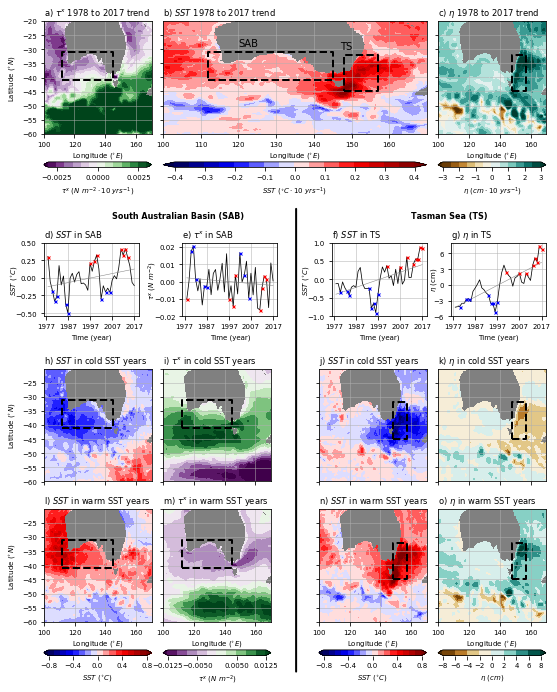

In [52]:
def bbox(pos):
    return matplotlib.transforms.Bbox(np.array([[pos[0],pos[1]],[pos[2],pos[3]]]))
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)
row = 5
col = 17
fig = plt.figure()
fig.set_size_inches(9,12)
matplotlib.rcParams.update({'font.size': 7}) 


##########################################################################################
ax = plt.subplot2grid((row, col), (0, 1-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.03, pos.x1-0.01, pos.y1+0.03] 
print(pos_plot)

levels = arange(-0.003,0.003,0.0005)
plot = plt.contourf(tau_x_slopes_40.longitude, tau_x_slopes_40.latitude, tau_x_slopes_40,
            cmap='PRGn', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
    [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
    color='k', linestyle='--', linewidth=2)

# levels = [0, 100]
# CS = tau_x_bl_mean.plot.contour(colors='k', levels=levels, linewidths=1)

ax.set_facecolor('gray')
plt.title(r'a) $\tau^{x}$ 1978 to 2017 trend', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,20))
plt.ylabel('Latitude ($^{\circ}N$)')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal', ticks=[-0.0025, 0, 0.0025],
                    label=r'$\tau^{x}\ (N\ m^{-2} \cdot 10\ yrs^{-1})$', cax=axins)
##########################################################################################

plt.text(+0.65,-9,'South Australian Basin (SAB)',fontweight='bold', fontsize=8)
plt.text(+3.7,-9,'Tasman Sea (TS)' ,fontweight='bold', fontsize=8)
plt.annotate('', xy=(2.34, -7), xytext=(2.34, -90), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle="-", color='k', linestyle='-', linewidth=2))

##########################################################################################
ax = plt.subplot2grid((row, col), (0, 5-1), rowspan=1, colspan=9)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.03, pos.x1, pos.y1+0.03] 
print(pos_plot)

levels = arange(-0.4,0.4,0.05)
plot = plt.contourf(temp_slopes_40.longitude, temp_slopes_40.latitude, temp_slopes_40,
            cmap='seismic', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.text(120,-29,'SAB',color='k',fontsize=10)
plt.text(147,-30,'TS',color='k',fontsize=10)
plt.plot(
    [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
    [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
    color='k', linestyle='--', linewidth=2)
plt.plot(
    [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
    [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'b) $SST$ 1978 to 2017 trend', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,10))
# plt.ylabel('Latitude ($^{\circ}N$)')
plt.gca().set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$SST\ (^{\circ}C \cdot 10\ yrs^{-1})$', cax=axins)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (0, 14-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0+0.01, pos.y0+0.03, pos.x1, pos.y1+0.03] 
print(pos_plot)

levels = arange(-3,3,0.5)
plot = plt.contourf(eta_t_slopes_40.longitude, eta_t_slopes_40.latitude, eta_t_slopes_40,
            cmap='BrBG', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
    [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'c) $\eta$ 1978 to 2017 trend', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,20))
# plt.ylabel('Latitude ($^{\circ}N$)')
plt.gca().set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$\eta\ (cm \cdot 10\ yrs^{-1})$', cax=axins)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (1, 5-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0+0.03, pos.y0-0.025, pos.x1, pos.y1-0.07] 
print(pos_plot)

plot = plt.plot(n_years, tau_x_anom_SA, color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [n_years[0], n_years[-1]], 
    [n_years[0]*tau_x_anom_SA_slope+tau_x_anom_SA_intrsct, n_years[-1]*tau_x_anom_SA_slope+tau_x_anom_SA_intrsct], 
    color='gray', linewidth=0.5)
plt.plot(
    years_warm_SA, tau_x_anom_SA_warm_unsort, 
    color='red', linestyle='', marker='x', markersize=3)
plt.plot(
    years_cold_SA, tau_x_anom_SA_cold_unsort, 
    color='blue', linestyle='', marker='x', markersize=3)

# ax.set_facecolor('gray')
plt.title(r'e) $\tau^{x}$ in SAB', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1977,2017,10), rotation=0)
plt.ylabel(r'$\tau^{x}$ ($N\ m^{-2})$', labelpad=-5)
plt.yticks(arange(-0.02,0.02,0.01))
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (1, 1-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.025, pos.x1-0.03, pos.y1-0.07] 
print(pos_plot)

plot = plt.plot(n_years, temp_anom_SA, color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [n_years[0], n_years[-1]], 
    [n_years[0]*temp_anom_SA_slope+temp_anom_SA_intrsct, n_years[-1]*temp_anom_SA_slope+temp_anom_SA_intrsct], 
    color='gray', linewidth=0.5)
plt.plot(
    years_warm_SA, temp_anom_SA_warm_unsort, 
    color='red', linestyle='', marker='x', markersize=3)
plt.plot(
    years_cold_SA, temp_anom_SA_cold_unsort, 
    color='blue', linestyle='', marker='x', markersize=3)

# ax.set_facecolor('gray')
plt.title('d) $SST$ in SAB', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1977,2017,10), rotation=0)
plt.ylabel(r'$SST$ ($^{\circ}C$)', labelpad=-5)
plt.yticks(arange(-0.5,0.5,0.25))
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (1, 10-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0+0.03, pos.y0-0.025, pos.x1-0.00, pos.y1-0.07] 
print(pos_plot)

plot = plt.plot(n_years, temp_anom_TS, color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [n_years[0], n_years[-1]], 
    [n_years[0]*temp_anom_TS_slope+temp_anom_TS_intrsct, n_years[-1]*temp_anom_TS_slope+temp_anom_TS_intrsct], 
    color='gray', linewidth=0.5)
plt.plot(
    years_warm_TS, temp_anom_TS_warm_unsort, 
    color='red', linestyle='', marker='x', markersize=3)
plt.plot(
    years_cold_TS, temp_anom_TS_cold_unsort, 
    color='blue', linestyle='', marker='x', markersize=3)

# ax.set_facecolor('gray')
plt.title('f) $SST$ in TS', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1977,2017,10), rotation=0)
plt.ylabel(r'$SST$ ($^{\circ}C$)', labelpad=-5)
plt.yticks(arange(-1,1,0.5))
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (1, 14-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0+0.03, pos.y0-0.025, pos.x1, pos.y1-0.07] 
print(pos_plot)

plot = plt.plot(n_years, eta_t_anom_TS, color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [n_years[0], n_years[-1]], 
    [n_years[0]*eta_t_anom_TS_slope+eta_t_anom_TS_intrsct, n_years[-1]*eta_t_anom_TS_slope+eta_t_anom_TS_intrsct], 
    color='gray', linewidth=0.5)
plt.plot(
    years_warm_TS, eta_t_anom_TS_warm_unsort, 
    color='red', linestyle='', marker='x', markersize=3)
plt.plot(
    years_cold_TS, eta_t_anom_TS_cold_unsort, 
    color='blue', linestyle='', marker='x', markersize=3)

# ax.set_facecolor('gray')
plt.title(r'g) $\eta$ in TS', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1977,2017,10), rotation=0)
plt.ylabel(r'$\eta$ (cm)', labelpad=-5)
plt.yticks(arange(-6,6,3))
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (2, 5-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.06, pos.x1-0.01, pos.y1-0.06] 
print(pos_plot)

levels = arange(-0.0125,0.0125,0.0025)
plot = plt.contourf(tau_x_cold_composite_SA.longitude, tau_x_cold_composite_SA.latitude, tau_x_cold_composite_SA,
            cmap='PRGn', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
    [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
    color='k', linestyle='--', linewidth=2)

# levels = [0, 100]
# CS = tau_x_bl_mean.plot.contour(colors='k', levels=levels, linewidths=1)

ax.set_facecolor('gray')
plt.title(r'i) $\tau^{x}$ in cold SST years', loc='left')
plt.xlabel('')
plt.xticks(arange(100,160,20))
ax.set_xticklabels('')
plt.ylabel('')
ax.set_yticklabels('')
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (2, 1-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.06, pos.x1-0.01, pos.y1-0.06] 
print(pos_plot)

levels = arange(-0.8,0.8,0.1)
plot = plt.contourf(temp_cold_composite_SA.longitude, temp_cold_composite_SA.latitude, temp_cold_composite_SA,
            cmap='seismic', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
    [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'h) $SST$ in cold SST years', loc='left')
plt.xlabel('')
plt.xticks(arange(100,160,20))
ax.set_xticklabels('')
plt.ylabel('Latitude ($^{\circ}N$)')
# ax.set_yticklabels('')
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (2, 10-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0+0.01, pos.y0-0.06, pos.x1, pos.y1-0.06] 
print(pos_plot)

levels = arange(-0.8,0.8,0.1)
plot = plt.contourf(temp_cold_composite_TS.longitude, temp_cold_composite_TS.latitude, temp_cold_composite_TS,
            cmap='seismic', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
    [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'j) $SST$ in cold SST years', loc='left')
plt.xlabel('')
plt.xticks(arange(100,160,20))
ax.set_xticklabels('')
plt.ylabel('')
ax.set_yticklabels('')
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (2, 14-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0+0.01, pos.y0-0.06, pos.x1, pos.y1-0.06] 
print(pos_plot)

levels = arange(-8,8,2)
plot = plt.contourf(eta_t_cold_composite_TS.longitude, eta_t_cold_composite_TS.latitude, eta_t_cold_composite_TS,
            cmap='BrBG', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
    [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'k) $\eta$ in cold SST years', loc='left')
plt.xlabel('')
plt.xticks(arange(100,160,20))
ax.set_xticklabels('')
plt.ylabel('')
ax.set_yticklabels('')
plt.grid(linewidth=0.5)
#########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (4, 5-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.09, pos.x1-0.01, pos.y1+0.09] 
print(pos_plot)

levels = arange(-0.0125,0.0125,0.0025)
plot = plt.contourf(tau_x_warm_composite_SA.longitude, tau_x_warm_composite_SA.latitude, tau_x_warm_composite_SA,
            cmap='PRGn', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
    [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
    color='k', linestyle='--', linewidth=2)

# levels = [0, 100]
# CS = tau_x_bl_mean.plot.contour(colors='k', levels=levels, linewidths=1)

ax.set_facecolor('gray')
plt.title(r'm) $\tau^{x}$ in warm SST years', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,20))
plt.ylabel(r'')
ax.set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$\tau^{x}\ (N\ m^{-2})$', cax=axins,
                   ticks=[-0.0125, -0.005, 0.005, 0.0125])
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (4, 1-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.09, pos.x1-0.01, pos.y1+0.09] 
print(pos_plot)

levels = arange(-0.8,0.8,0.1)
plot = plt.contourf(temp_warm_composite_SA.longitude, temp_warm_composite_SA.latitude, temp_warm_composite_SA,
            cmap='seismic', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
    [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'l) $SST$ in warm SST years', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,20))
plt.ylabel('Latitude ($^{\circ}N$)')
# ax.set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$SST$ ($^{\circ}C$)', cax=axins,
                   ticks=[-0.8, -0.4, 0, 0.4, 0.8])
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (4, 10-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0+0.01, pos.y0+0.09, pos.x1, pos.y1+0.09] 
print(pos_plot)

levels = arange(-0.8,0.8,0.1)
plot = plt.contourf(temp_warm_composite_TS.longitude, temp_warm_composite_TS.latitude, temp_warm_composite_TS,
            cmap='seismic', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
    [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'n) $SST$ in warm SST years', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,20))
plt.ylabel('')
ax.set_yticklabels('')
plt.grid(linewidth=0.5)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$SST$ ($^{\circ}C$)', cax=axins,
                   ticks=[-0.8, -0.4, 0, 0.4, 0.8])
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (4, 14-1), rowspan=1, colspan=4)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0+0.01, pos.y0+0.09, pos.x1, pos.y1+0.09] 
print(pos_plot)

levels = arange(-8,8,2)
plot = plt.contourf(eta_t_warm_composite_TS.longitude, eta_t_warm_composite_TS.latitude, eta_t_warm_composite_TS,
            cmap='BrBG', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
    [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'o) $\eta$ in warm SST years', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,20))
plt.ylabel('')
ax.set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.3, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$\eta$ ($cm$)', cax=axins)
##########################################################################################


# fig.tight_layout()


output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig2_.png', bbox_inches='tight', dpi=300)